In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import time

import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer
import qiskit as qiskit
import qiskit.quantum_info as qi
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
import Ramsey_ExperimentV2
import random
import importlib
from tqdm import tqdm
import ramsey_experiment

# Loading your IBM Quantum account(s)
IBMQ.save_account(os.environ.get('IBM_KEY'), overwrite=True)
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-research')




C:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
ibmqfactory.load_account:WARNING:2024-01-21 10:27:55,137: Credentials are already in use. The existing account in the session will be replaced.


In [3]:
import Ramsey_ExperimentV2
import random
import importlib
from tqdm import tqdm
import numpy as np
ramsey_experiment = importlib.reload(Ramsey_ExperimentV2)
RamseyExperiment = ramsey_experiment.RamseyExperiment
RamseyBatch = ramsey_experiment.RamseyBatch

In [4]:
n = 3
shots = 1000
T = 0.2*np.pi
dist_decay = []
dist_w = []
dist_j = []
#measurements = np.arange(5,105,5)
measurements = 10
repetitions = 10
mean_w_dist = []
mean_decay_dist = []
mean_j_dist = []

W = [3]*n
J = [3]*(n-1)
l = np.linspace(1,5,10)
L = [[l[i]]*n for i in range(len(l))]

for i in range(repetitions):
    #W = [random.gauss(5, 2) for _ in range(n)]
    #L = [random.gauss(4, 2) for _ in range(n)]
    #J = [random.gauss(5, 2) for _ in range(n - 1)]
    dist_decay = []
    dist_w = []
    dist_j = []
    for decay in L:
        batch_det = []
        batch_cross = []
        delay = np.linspace(0, T, measurements)
        for t in tqdm(delay, desc='Creating experiments'):
            exp_det = RamseyExperiment(n, t, shots, J, W, decay)
            exp_det.create_circuit_detuning()
            exp_det.add_decay_raw()
            batch_det.append(exp_det)

            exp_cross = RamseyExperiment(n, t, shots, J, W, decay)
            exp_cross.create_circuit_crosstalk()
            exp_cross.add_decay_raw()
            batch_cross.append(exp_cross)

        batch_det = RamseyBatch(batch_det)
        params_det = batch_det.fit_to_theory()
        batch_cross = RamseyBatch(batch_cross)
        params_cross = batch_cross.fit_to_theory()
        crosstalk_qubits_measured = batch_cross.qubits_measured
        W_fit = [params_det[i][1] for i in range(n)]
        J_fit = [params_cross[i][1] - W_fit[crosstalk_qubits_measured[i]] for i in range(n-1)]
        decay_fit = [params_det[i][0] for i in range(n)]


        dist_w.append(batch_det.calc_dist(W_fit,W))
        dist_decay.append(batch_det.calc_dist(decay_fit,decay))
        dist_j.append(batch_det.calc_dist(J_fit,J))
    mean_decay_dist.append(dist_decay)
    mean_w_dist.append(dist_w)
    mean_j_dist.append(dist_j)
    #dist_j.append(batch_det.calc_dist(J_fit,J))




Creating experiments: 100%|██████████| 10/10 [00:00<00:00, 21.00it/s]


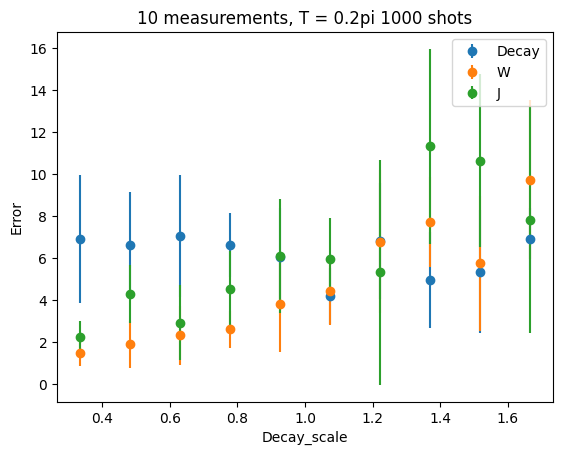

In [6]:
import matplotlib.pyplot as plt
w_dist_reshaped = list(map(list, zip(*mean_w_dist)))
w_error = [np.median(np.array(w_dist_reshaped[i])) for i in range(len(w_dist_reshaped))]
w_std = [np.std(np.array(w_dist_reshaped[i])) for i in range(len(w_dist_reshaped))]

decay_dist_reshaped = list(map(list, zip(*mean_decay_dist)))
decay_error = [np.median(np.array(decay_dist_reshaped[i])) for i in range(len(decay_dist_reshaped))]
decay_std = [np.std(np.array(decay_dist_reshaped[i])) for i in range(len(decay_dist_reshaped))]

j_dist_reshaped = list(map(list, zip(*mean_j_dist)))
j_error = [np.median(np.array(j_dist_reshaped[i])) for i in range(len(j_dist_reshaped))]
j_std = [np.std(np.array(j_dist_reshaped[i])) for i in range(len(j_dist_reshaped))]

plt.title('10 measurements, T = 0.2pi 1000 shots')
plt.xlabel('Decay_scale')
plt.ylabel('Error')

decay_factor = [l[i]/W[0] for i in range(len(l))]


plt.errorbar(decay_factor, decay_error, yerr=decay_std, fmt='o', label='Decay')
plt.errorbar(decay_factor, w_error, yerr=w_std, fmt='o', label='W')
plt.errorbar(decay_factor, j_error, yerr=j_std, fmt='o', label='J')
#lt.semilogy()
#plt.ylim([0,100])
plt.legend()

In [14]:
import pandas as pd

w_df = pd.DataFrame({'w_dist_reshaped': w_dist_reshaped, 'w_error': w_error, 'w_std' : w_std})
decay_df = pd.DataFrame({'decay_dist_reshaped': decay_dist_reshaped, 'decay_error': decay_error, 'decay_std' : decay_std})
j_df = pd.DataFrame({'j_dist_reshaped': j_dist_reshaped, 'j_error': j_error, 'j_std' : j_std})

# Save the DataFrame to an Excel file
excel_path = 'results/w_df.xlsx'
w_df.to_excel(excel_path, index=False)

excel_path = 'results/decay_df.xlsx'
decay_df.to_excel(excel_path, index=False)

excel_path = 'results/j_df.xlsx'
j_df.to_excel(excel_path, index=False)

In [10]:
import pandas as pd

excel_path = 'results/w_df.xlsx'
df = pd.read_excel(excel_path)
w_dist_reshaped = df['w_dist_reshaped'].tolist()
w_error = df['w_error'].tolist()
w_std = df['w_std'].tolist()

excel_path = 'results/decay_df.xlsx'
df = pd.read_excel(excel_path)
decay_dist_reshaped = df['decay_dist_reshaped'].tolist()
decay_error = df['decay_error'].tolist()
decay_std = df['decay_std'].tolist()

excel_path = 'results/j_df.xlsx'
df = pd.read_excel(excel_path)
j_dist_reshaped = df['j_dist_reshaped'].tolist()
j_error = df['j_error'].tolist()
j_std = df['j_std'].tolist()
